In [1]:
!pip install pyDOE

In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.8.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
from scipy.stats import norm
#getting collocation points
x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
t = np.linspace(0, 0.1, 1000)                     # 100 time points between 0 and 1 [100x1] 
usol=np.zeros((256,1000))
usol[:,0][:]=norm.pdf(x,0,0.05).T

#collocation points for every position and every time
X, T = np.meshgrid(x,t)


# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [3]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u = usol.flatten('F')[:,None] 

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [4]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train 


# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [5]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
    
        cost=1 
        sigma2=0.1

        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            p_x = tape.gradient(z,x_f)

        p_t = tape.gradient(z,t_f)    
        p_xx = tape.gradient(p_x, x_f)

        del tape

        p=self.evaluate(g)

        f = p_t - cost * p - cost * x_f * p_x - sigma2/2*p_xx

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(loss_value, loss_u, loss_f, error_vec)

# *Solution Plot*

In [6]:
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(2, 3)
    gs0.update(top=1, bottom=0, left=0.1, right=2, wspace=0.3, hspace =0.4)
    ax = plt.subplot(gs0[0, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    #gs1 = gridspec.GridSpec(1, 3)
    #gs1.update(top=0.3, bottom=-0.1, left=0.1, right=2, wspace=0.5)

    ax = plt.subplot(gs0[1, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.s$', fontsize = 10)
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])

    ax = plt.subplot(gs0[1, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[500,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])
    ax.set_title('$t = 0.05s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs0[1, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[750,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])    
    ax.set_title('$t = 0.075s$', fontsize = 10)
    
    #plt.tight_layout()
    plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)   

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

Metal device set to: Apple M1
0.39221483702389653 0.26664840748791124 0.12556642953598529 1.6922120607591502
0.33604792317989191 0.2649745811503833 0.0710733420295086 1.6843058220258518
0.31643913540042307 0.26041095386342478 0.056028181536998296 1.4236627758643314
0.27736138213378342 0.25220180316094287 0.025159578972840532 1.3064495242759384
0.26633582056435295 0.25242997564716269 0.013905844917190267 1.6535107012859922
0.26480990675549654 0.252981167452206 0.011828739303290521 1.7562295057005015
0.26408206905684195 0.25328250846237244 0.010799560594469524 1.7808348584629174
0.26228747251545842 0.25402477849635441 0.0082626940191040318 1.8030006635527362
0.26091144969291946 0.25441182126353368 0.006499628429385786 1.7714982379146529
0.26033773030232354 0.25440129799999989 0.0059364323023236654 1.718693401792519
0.260203160301993 0.25427607730531054 0.0059270829966824512 1.6917754497754314
0.260053245208297 0.2540999035823438 0.0059533416259531886 1.6645382391488264
0.2596685028599701

0.22431741029266622 0.21890441472932373 0.0054129955633424858 5.271062419347275
0.223753831601252 0.21792183370430643 0.0058319978969455857 5.3162963367230684
0.22309723454320063 0.21767039801665228 0.0054268365265483622 5.363467877828526
0.22217341738149 0.21652645766507886 0.00564695971641113 5.53202686538521
0.2214992715124503 0.21626586478368121 0.00523340672876911 5.680577605524947
0.21989553910247123 0.21474121415714523 0.005154324945325992 5.902689503201164
0.21869704021428241 0.2096698028553538 0.0090272373589286026 6.396298961354172
0.21405824763080233 0.20837926635329385 0.0056789812775084846 6.481383416921955
0.20969148882437186 0.20331835058414721 0.0063731382402246479 6.815723845434964
0.20712786949979337 0.19974574355092095 0.0073821259488724266 7.064092435877654
0.20382753363194003 0.19349523089506823 0.010332302736871801 7.497865511531525
0.19923001443483479 0.18102008991760163 0.018209924517233161 8.613408657836608
0.19766534693374377 0.1811093661233707 0.0165559808103

0.075593432023046442 0.066433280603963168 0.0091601514190832768 21.015400289264942
0.075463314577558338 0.066223934529514444 0.0092393800480439 21.037100230234905
0.075360890347695164 0.066017768418708447 0.00934312192898672 21.079078008179163
0.075211929299677779 0.065947808297702137 0.0092641210019756455 21.042129390745483
0.074913219782812651 0.065541516559030066 0.0093717032237825865 20.992651539790906
0.074592524907480764 0.065132383569067 0.0094601413384137571 20.820093148884517
0.074198369411942439 0.064282894747401481 0.0099154746645409523 20.716025789593225
0.074017748928741342 0.062877411847190368 0.011140337081550974 20.66878584181948
0.073850948423315535 0.063141444050589524 0.010709504372726011 20.534337111671203
0.073615835405568555 0.06263099432796819 0.010984841077600371 20.667005642094175
0.0732645162943957 0.061719667893010685 0.011544848401385014 20.735705417856572
0.07271064198468237 0.060772559217703685 0.011938082766978683 20.817056437159135
0.0715102409957252 0.0

0.036735826159304416 0.027261871500820753 0.0094739546584836614 22.586775729509792
0.036380444326783938 0.026854279807199746 0.0095261645195841918 22.474864385028766
0.036187558723668856 0.025940345935096167 0.010247212788572687 22.45516739731854
0.03602254686277627 0.025767994185811879 0.010254552676964391 22.407124186875183
0.035915710805031531 0.025524321295865994 0.01039138950916554 22.442974682410878
0.03584257309574336 0.025261828180874881 0.010580744914868481 22.47988374762239
0.0357244915176378 0.025074184210813713 0.010650307306824085 22.54879033576419
0.035547136497430611 0.024585690168974817 0.010961446328455795 22.672258403577054
0.035305773920222723 0.024266865164156569 0.011038908756066156 22.74163827892512
0.03505882298902311 0.023528508375024827 0.011530314613998281 22.824654555389067
0.034913112414368189 0.02346116316738675 0.011451949246981442 22.75109360794123
0.034824892569548661 0.023228915132169591 0.011595977437379073 22.69286713698401
0.034765137546567342 0.0233

0.01539699444322667 0.00880557633653741 0.00659141810668926 23.48509485359485
0.015382298119298803 0.00881750088389477 0.0065647972354040329 23.50095349078149
0.015363288701519921 0.0087983059915629162 0.0065649827099570051 23.517695461451215
0.015296072611276381 0.0086832892537822871 0.0066127833574940948 23.556608760022378
0.015190331612029682 0.0084950653103571076 0.006695266301672575 23.59418643210899
0.014984967521248994 0.0080850952278621688 0.0068998722933868249 23.645199547169135
0.014777504117114733 0.0076015497165104751 0.0071759544006042581 23.686562940920606
0.014627678187986413 0.0073936669078445818 0.007234011280141831 23.64437263419563
0.014505632846210705 0.0073212238771872846 0.00718440896902342 23.63571493262827
0.014479557430012176 0.0072952154668588379 0.0071843419631533369 23.613809185372332
0.014428253167785048 0.00733089045943481 0.007097362708350239 23.637089981312457
0.014393314905898475 0.0073487318826406384 0.0070445830232578367 23.670840755250236
0.014373774

0.0071326861588639785 0.0031208432921277225 0.0040118428667362555 24.271816323037267
0.0070605207190074324 0.0030954302230048795 0.0039650904960025525 24.21909952856157
0.0069448908987940604 0.0030762882346450329 0.0038686026641490279 24.077832802644327
0.0068873776754001369 0.0031664328036163009 0.0037209448717838364 23.984218391455556
0.0067680208450559545 0.003115304925045912 0.0036527159200100425 23.993536502149514
0.0067040750994946351 0.003134667496558352 0.0035694076029362831 23.994296722009693
0.006630513245212087 0.0030480381497958522 0.0035824750954162347 24.028406236294362
0.0065815749915639175 0.0029676469511306378 0.00361392804043328 24.026426434151055
0.0065333634967742072 0.0028594423223187704 0.0036739211744554372 23.996595028274665
0.006494552181853892 0.0027261203131517487 0.0037684318687021437 23.976480759799294
0.0064705349862323449 0.0026278868892733575 0.0038426480969589874 23.963566053507346
0.0064537032390851561 0.0026626998629715169 0.0037910033761136388 23.936

0.0041705806604424543 0.0016110026856505164 0.0025595779747919377 24.882778967293795
0.0041375981372259295 0.0016819919125442763 0.0024556062246816534 24.87340434538118
0.0041106295159737943 0.0017771649930633502 0.002333464522910444 24.86265562692789
0.0040728897255623026 0.0018000009130060249 0.0022728888125562777 24.79691251162467
0.0040471456224369096 0.0018197431631310486 0.0022274024593058614 24.781492581707756
0.0040235576991200159 0.0018227851833427851 0.0022007725157772305 24.77667605323181
0.0039975142981819234 0.0017756599265804618 0.0022218543716014615 24.765582374800395
0.0039712220349976627 0.001755340510916589 0.002215881524081074 24.72218796129568
0.00395585217821766 0.001716554570916912 0.0022392976073007482 24.699156692070574
0.0039413443367826871 0.0017256530509055068 0.0022156912858771805 24.656890866476978
0.003930296053321387 0.0017652340385531007 0.0021650620147682866 24.599708591971662
0.0039226603886296646 0.0017781474232352824 0.0021445129653943824 24.59079559

0.0023932371965001663 0.00037936388256860931 0.0020138733139315572 24.81748609345771
0.0023883735207573318 0.00037604154067406127 0.0020123319800832706 24.814974072272562
0.0023802185156696462 0.00037361236931136171 0.0020066061463582846 24.82586144996309
0.0023766536565036412 0.00037787217818197467 0.0019987814783216664 24.829454366964285
0.0023734998809855305 0.00039088032182712536 0.001982619559158405 24.832238741573477
0.0023723660410263315 0.00039312348223008681 0.0019792425587962449 24.828262787187185
0.0023714252080188295 0.00039267388682220889 0.0019787513211966205 24.825384255660747
0.0023675056599337151 0.00039543851494577733 0.0019720671449879375 24.81987799225779
0.0023612606415534887 0.00039796946220789541 0.0019632911793455933 24.807301029256315
0.0023498310113152219 0.00039337999743489359 0.0019564510138803284 24.802449977505535
0.0023321727462570973 0.0003770401163051306 0.0019551326299519669 24.812609695182214
0.0023223046577824031 0.00035213385874685425 0.001970170799

0.0017219158188811739 0.00039205246098260045 0.0013298633578985733 24.95640287121731
0.0017164650334062447 0.00039455805136435964 0.001321906982041885 24.945003467448867
0.0017104050391906751 0.00039670663846813826 0.0013136984007225368 24.92405658271639
0.0016989382306818917 0.00039507426777797306 0.0013038639629039186 24.910415168773845
0.0016860962857548445 0.000383386915310661 0.0013027093704441833 24.907135360710473
0.0016579885650974096 0.00035024019231065718 0.0013077483727867525 24.935116973303035
0.0016455493308117639 0.00032113392706263405 0.0013244154037491298 24.928950665260356
0.0016308201976892259 0.00032244181050498775 0.0013083783871842382 24.922925077055314
0.0016159834196801076 0.00031945285873179115 0.0012965305609483164 24.939894597232332
0.0016069456420848547 0.00032553253565474946 0.0012814131064301053 24.931567319474894
0.001595633477636191 0.00032320840362527693 0.0012724250740109139 24.900173724025596
0.0015862317324129055 0.00031103695303099374 0.0012751947793

0.0011461472032115332 0.00017593665266721575 0.0009702105505443176 24.83528996853309
0.0011432023497764173 0.00017483261758974311 0.0009683697321866741 24.837696210066746
0.0011406540565173523 0.0001747869969430014 0.00096586705957435091 24.836240348538738
0.0011374972687235442 0.00017488075760320549 0.00096261651112033867 24.82952840383823
0.0011332011929177086 0.0001696225393047034 0.00096357865361300517 24.83189318360551
0.0011272907001316573 0.00016094483479133542 0.00096634586534032182 24.838538671089402
0.0011216861762945517 0.00014935351730170965 0.00097233265899284208 24.84683105623881
0.0011168984379020914 0.00014421756226789861 0.00097268087563419283 24.853384782222893
0.0011134818747967315 0.00014175391895849957 0.000971727955838232 24.853727552397828
0.0011067896408845531 0.00014562513916293376 0.00096116450172161936 24.84233208085512
0.0011055040312241871 0.00015662133303093813 0.00094888269819324883 24.834420640010546
0.0010980859241599931 0.00014875961959105207 0.0009493

0.00094446486358750728 0.00010162820550188654 0.00084283665808562074 25.014804066170385
0.00094117042467450516 9.9180853368230283e-05 0.00084198957130627488 25.010801172520658
0.00093622201253117966 9.6609265603261264e-05 0.00083961274692791838 24.997360803090128
0.00093065388307705975 9.5399755566923791e-05 0.00083525412751013592 24.99525492921568
0.00092275320084582956 9.8226723203415778e-05 0.00082452647764241381 24.990466327609443
0.00091378804561249318 0.00010091073949189905 0.00081287730612059409 24.981927030772656
0.0009053228513423141 0.00010405734637129617 0.00080126550497101792 24.987121442055884
0.00089242796332433957 0.00010242987289510833 0.00078999809042923125 24.99676516353261
0.00088296847244396625 0.00010028652983559377 0.00078268194260837246 25.027492178800678
0.000878948238899629 9.9117411253804333e-05 0.00077983082764582462 25.036366690863456
0.00087116252699226534 0.00010210896228076629 0.000769053564711499 25.090687547555486
0.00086692923679673316 0.00010312530845

0.00067153607191847251 7.62101899452666e-05 0.0005953258819732059 25.06069504654565
0.00066638349608452512 7.2516011319613075e-05 0.000593867484764912 25.064190711127676
0.00066454383383082131 6.9565246964538435e-05 0.00059497858686628291 25.05661119719065
0.00066212926170042925 6.8461263295055579e-05 0.00059366799840537365 25.05463294478069
0.000661529510684221 6.8927328971242079e-05 0.000592602181712979 25.056914178817465
0.00066023405605909258 6.8460733794831367e-05 0.00059177332226426126 25.062160655057138
0.0006587166694231809 6.789411884699561e-05 0.0005908225505761853 25.07005335485357
0.00065729371627002873 6.7970693560976081e-05 0.00058932302270905262 25.077624251865707
0.00065476711707452694 6.8455756295813161e-05 0.00058631136077871382 25.07181806956995
0.00065194125045403193 6.8710618270140161e-05 0.00058323063218389173 25.066090892905617
0.00064901439014828385 7.0880086584815759e-05 0.0005781343035634681 25.060907407311323
0.00064617440835490448 7.0152058487776839e-05 0.00

0.00050421222426990135 6.8803565487732864e-05 0.00043540865878216849 25.094066954205996
0.00050392449793140064 6.8765080082718448e-05 0.00043515941784868215 25.09554768782123
0.00050366396718411026 6.8535074331341545e-05 0.00043512889285276867 25.093360585946748
0.00050346960263951456 6.8115816108112778e-05 0.00043535378653140173 25.089968194678395
0.000503361051820641 6.7820339257305609e-05 0.00043554071256333542 25.088361834069993
0.00050326512869421449 6.7526102834379064e-05 0.00043573902585983547 25.08714330362734
0.00050311098129975865 6.735177209887515e-05 0.00043575920920088348 25.085618138955585
0.00050275486240764368 6.7322500856499711e-05 0.00043543236155114392 25.084004441180415
0.00050203650854633176 6.7571691195454951e-05 0.00043446481735087678 25.080738178392313
0.0005005014054332152 6.815559812356912e-05 0.0004323458073096461 25.078909920252773
0.000497445841193881 6.9455328939511336e-05 0.00042799051225436973 25.073782074088367
0.00049357076774285955 7.1621911600857041e

0.00044154550871157374 8.82763987784527e-05 0.000353269109933121 25.064704865941568
0.00044119144287296666 8.8488933039887143e-05 0.00035270250983307955 25.06751871472258
0.00044068227437751688 9.0472049418335225e-05 0.00035021022495918165 25.06912136618867
0.0004405374359608377 9.0520850091512531e-05 0.00035001658586932514 25.067931668252385
0.00044034516893793707 9.0354718824281317e-05 0.00034999045011365577 25.068952855722973
0.00043998960687256149 8.98770777150639e-05 0.00035011252915749758 25.070998085223685
0.00043952378295704982 8.8995030766410074e-05 0.00035052875219063976 25.073219098572324
0.00043909906566819352 8.914950318933396e-05 0.00034994956247885956 25.07314928218672
0.00043841702697890032 9.01982775776153e-05 0.000348218749401285 25.06933932422906
0.00043812725675032159 9.0777933428298118e-05 0.00034734932332202345 25.067963976888265
0.00043782693863635684 9.2752136815482441e-05 0.00034507480182087441 25.065013984016712
0.00043731766149532466 9.34151228635765e-05 0.00

0.00038479815644949572 7.5726965053245581e-05 0.00030907119139625015 25.11674389146461
0.00038409862945255083 7.6839698059358256e-05 0.00030725893139319258 25.113371997306366
0.00038342115174327788 7.5733231272234221e-05 0.00030768792047104369 25.111304555961933
0.00038286225718181776 7.3596325869733058e-05 0.00030926593131208472 25.108745203505567
0.00038251057468290464 7.26840355447014e-05 0.00030982653913820324 25.10833800003323
0.00038203556510250328 7.2315814721729982e-05 0.00030971975038077327 25.107921159882974
0.00038087270769153838 7.0956200058594937e-05 0.00030991650763294347 25.109105064985233
0.00037955434620810986 7.0210985101958333e-05 0.0003093433611061515 25.108516183610593
0.00037744381232596722 7.02055801013651e-05 0.00030723823222460211 25.11141984212661
0.00037647718083036561 6.9349394043565656e-05 0.00030712778678679997 25.111958857574358
0.00037490348942220659 6.9741516556610917e-05 0.00030516197286559567 25.11920189189052
0.00037373459232630185 7.0026385148676593

0.0003402377408364992 5.7682895593823828e-05 0.00028255484524267535 25.1106493795944
0.0003387380108408047 5.6494974241034476e-05 0.0002822430365997702 25.11446351619356
0.0003381330508157918 5.6918933212972711e-05 0.00028121411760281909 25.115441233200293
0.00033663955223305406 5.6823233270035627e-05 0.00027981631896301844 25.114535862113257
0.00033626705588571284 5.7473841157436832e-05 0.000278793214728276 25.11308157973548
0.00033564856175755711 5.7402496715015111e-05 0.000278246065042542 25.110235033099663
0.00033492884393722421 5.707144805850906e-05 0.00027785739587871518 25.106874226462313
0.00033368950638222421 5.6794765168396389e-05 0.00027689474121382781 25.10836664646064
0.00033312426760435146 5.6534941887427554e-05 0.00027658932571692391 25.107046190692206
0.00033259588978016517 5.619289749644141e-05 0.00027640299228372375 25.104325792874082
0.00033235542768078423 5.6000290304782891e-05 0.00027635513737600135 25.102490135178595
0.00033200512329046715 5.589942981958841e-05 0.

0.00025130717902626363 3.071431376983923e-05 0.00022059286525642438 25.133901221779748
0.00025069345088201642 3.0177789314037818e-05 0.00022051566156797861 25.1391999515938
0.00025044969070347795 2.9645856050479271e-05 0.00022080383465299867 25.137643618547045
0.00025002776046867381 2.9799564365775789e-05 0.00022022819610289805 25.132642083750923
0.00024957639391950162 3.0164695705568059e-05 0.00021941169821393356 25.130673703707927
0.00024925993693866543 2.9359863976488627e-05 0.00021990007296217681 25.132671677964037
0.00024882592872485883 2.9443132692375851e-05 0.00021938279603248297 25.129305632899943
0.00024851857511723648 2.9285872546508663e-05 0.00021923270257072781 25.1279035905175
0.00024806282901727042 2.8770940321893122e-05 0.00021929188869537728 25.127692141435467
0.00024800579816558265 2.8829485458150741e-05 0.00021917631270743193 25.123963033466808
0.00024750910928886174 2.8461943654965005e-05 0.00021904716563389675 25.125280175494275
0.00024705122557021732 2.775179962817

0.00022928983716105769 2.6427191713139334e-05 0.00020286264544791836 25.132029677200045
0.00022916228623530926 2.6200956682853139e-05 0.00020296132955245611 25.13147235252033
0.00022904697403995132 2.6118834145712534e-05 0.00020292813989423878 25.131834172773146
0.0002289243809270229 2.606081623462568e-05 0.00020286356469239721 25.13126806956199
0.0002287870096654804 2.57628438986732e-05 0.00020302416576680721 25.13023790019602
0.00022866339233679986 2.5571524872902817e-05 0.00020309186746389704 25.129277102772285
0.00022855055781645904 2.5394650525108073e-05 0.00020315590729135096 25.12853826547492
0.00022850551479768522 2.5505360765898536e-05 0.00020300015403178668 25.127702116807296
0.00022836236567523059 2.5268298918610051e-05 0.00020309406675662054 25.127754121116652
0.00022827572657106599 2.51081388871278e-05 0.00020316758768393819 25.12764767015846
0.00022808344421334297 2.4883951167415727e-05 0.00020319949304592724 25.12854139280553
0.000227866515785329 2.4673148681012037e-05 0

0.00020457631829683091 2.3936451034901145e-05 0.00018063986726192977 25.124751146763945
0.00020445217223112922 2.4138634173637772e-05 0.00018031353805749144 25.11987324096499
0.000204300197649607 2.40563333098742e-05 0.0001802438643397328 25.11857588167968
0.0002041737105579564 2.3865988079650003e-05 0.0001803077224783064 25.117933428455732
0.00020404713850068974 2.3604882819605969e-05 0.00018044225568108376 25.11838595070672
0.00020398222640076336 2.3409363052717035e-05 0.00018057286334804631 25.117572716437948
0.00020395888472680583 2.3381141244646372e-05 0.00018057774348215945 25.11797630726615
0.00020392203961725787 2.3299457170983709e-05 0.00018062258244627417 25.119119834645627
0.00020389084181520419 2.335977204661513e-05 0.00018053106976858907 25.119887472428744
0.00020385373714190621 2.3419108785212244e-05 0.00018043462835669398 25.120504007535892
0.00020380631348646439 2.3138453923700956e-05 0.00018066785956276344 25.122798223237773
0.00020375303267284347 2.3325023860391765e-0

0.00019744446582122544 2.2380385889394077e-05 0.00017506407993183137 25.108458239722847
0.00019722818562362758 2.2253814376327867e-05 0.00017497437124729972 25.107979505957548
0.00019709429225087422 2.2439822962565651e-05 0.00017465446928830857 25.10665609699574
0.00019703457004003916 2.2500499133248291e-05 0.00017453407090679086 25.10649566255982
0.000196797451746898 2.251731502202637e-05 0.00017428013672487162 25.10360925108416
0.00019670950016576052 2.2798861847111697e-05 0.00017391063831864883 25.106565368291452
0.00019661226730352836 2.271514239958964e-05 0.00017389712490393873 25.106513639841406
0.0001964591033312341 2.2686772824104841e-05 0.00017377233050712925 25.104532870180925
0.000196391012700053 2.2832755563013889e-05 0.0001735582571370391 25.104527036554334
0.00019631080281547878 2.2813064524012811e-05 0.00017349773829146596 25.106210883414246
0.00019623031469918409 2.2758651271292787e-05 0.00017347166342789131 25.10679084539347
0.00019616576329976125 2.2782423871968405e-0

0.00017704876673982944 2.4243746029090864e-05 0.00015280502071073857 25.110127260517306
0.0001768884067694612 2.4260254627517437e-05 0.00015262815214194377 25.11082487812682
0.00017680396497466927 2.4255622010690195e-05 0.00015254834296397907 25.110433034223465
0.00017667807037544047 2.4109610577826576e-05 0.00015256845979761389 25.10998526075651
0.00017663522544502497 2.4034557250249631e-05 0.00015260066819477533 25.10888898296776
0.00017648806418625151 2.4167381192241998e-05 0.00015232068299400953 25.10982554126474
0.000176399983833749 2.4157257930637449e-05 0.00015224272590311154 25.10892467660377
0.00017624142235239261 2.4173415041118167e-05 0.00015206800731127444 25.108422726007337
0.00017599506154219395 2.4262033131226697e-05 0.00015173302841096724 25.10751182779848
0.00017578827630395169 2.4292397319011202e-05 0.0001514958789849405 25.10899667193233
0.00017563777830450857 2.4490546888265913e-05 0.00015114723141624266 25.110335850203285
0.0001754667571634013 2.4569362452556912e-0

0.00016087621618711997 1.7425120738335118e-05 0.00014345109544878484 25.111304108063628
0.00016069406807564429 1.7567857230059194e-05 0.00014312621084558509 25.109705630074846
0.00016047702938871224 1.7882108288797897e-05 0.00014259492109991434 25.107664478977725
0.00016025739114522517 1.8105561670022867e-05 0.00014215182947520231 25.10732075865976
0.00016011147076179123 1.8467833715475496e-05 0.00014164363704631574 25.108530892490005
0.0001599073812661013 1.836639305437536e-05 0.00014154098821172594 25.109404716943466
0.00015974626944278769 1.8140955055173414e-05 0.00014160531438761427 25.11020536724101
0.00015958177556288337 1.7946719168806996e-05 0.00014163505639407637 25.110437061087165
0.0001595455189371344 1.7537125597651953e-05 0.00014200839333948243 25.10867254793123
0.00015937756055390634 1.7694734156944687e-05 0.00014168282639696165 25.1069302738809
0.00015928577772138185 1.7660765712658109e-05 0.00014162501200872373 25.10535718866669
0.00015914732390548818 1.7528606878468481

0.0001402244603301613 2.1354106169658e-05 0.00011887035416050328 25.122352270604686
0.00014003384398916322 2.1260088887761843e-05 0.00011877375510140138 25.12255033346398
0.00013992462432794013 2.1228097568092359e-05 0.00011869652675984778 25.122117972396627
0.00013979995703771459 2.09767346724693e-05 0.00011882322236524529 25.12130213106728
0.0001396914061978341 2.0704876517029185e-05 0.00011898652968080493 25.122368902595646
0.00013949828851423317 2.0239446611579422e-05 0.00011925884190265375 25.123588436813353
0.0001393190867979779 1.9942041969628913e-05 0.00011937704482834898 25.12322778212864
0.00013914009217474416 1.9676471948306569e-05 0.00011946362022643758 25.121471465055997
0.00013902529052718811 1.9690092215328739e-05 0.00011933519831185937 25.118269745040287
0.00013892986800818566 2.0002535840535652e-05 0.00011892733216765 25.115230315931388
0.00013877298991996518 2.0181196783554304e-05 0.00011859179313641087 25.1150249770044
0.0001386777504269891 2.0164270492294516e-05 0.0

0.00012051724555261482 2.3398210767203907e-05 9.711903478541091e-05 25.116287170910535
0.00012045705185066219 2.3242025359952611e-05 9.7215026490709579e-05 25.11639939379308
0.00012033128689412667 2.3238452978897586e-05 9.7092833915229091e-05 25.116544759475126
0.00012010024279013512 2.3293476655074889e-05 9.6806766135060227e-05 25.117083758239357
0.00011995718163925068 2.3320793972798681e-05 9.6636387666452e-05 25.11672219651685
0.00011971179727697764 2.3431584642898458e-05 9.6280212634079174e-05 25.115795395536033
0.00011935377628503682 2.3543587517373085e-05 9.5810188767663738e-05 25.115927445417785
0.00011881928950652277 2.3628362601472372e-05 9.51909269050504e-05 25.1167274640807
0.00011797331599879747 2.3872670732772313e-05 9.4100645266025166e-05 25.121378065870807
0.00011715141978073008 2.3882622554634464e-05 9.32687972260956e-05 25.127466137694917
0.00011675567856677849 2.4025266057740463e-05 9.2730412509038024e-05 25.12997063572275
0.00011637036615296664 2.4245495145330095e-05

0.00010855460601215537 2.1946873674553039e-05 8.6607732337602323e-05 25.127840173805787
0.00010852812383985005 2.1997242981088876e-05 8.6530880858761176e-05 25.127693728816983
0.00010850754896050044 2.2076458647710472e-05 8.6431090312789975e-05 25.127405815126043
0.00010850071540402692 2.2131369321411458e-05 8.6369346082615459e-05 25.127128632734703
0.00010846973968568416 2.2073121578444114e-05 8.6396618107240051e-05 25.127600621369275
0.00010844036262274737 2.2046030477890443e-05 8.639433214485692e-05 25.128220790872433
0.00010836101414287729 2.2049654686734822e-05 8.6311359456142471e-05 25.130267643893255
0.00010830054884566509 2.1960277481839538e-05 8.6340271363825552e-05 25.13144440153956
0.0001082191105500214 2.1882012558994455e-05 8.6337097991026938e-05 25.133026342928083
0.00010813421701068411 2.1861844684031094e-05 8.6272372326653019e-05 25.133621805742898
0.00010809939631885245 2.1834795485101281e-05 8.6264600833751173e-05 25.13370716495459
0.00010806519786969731 2.18234177002

0.00010007298947006332 1.9677773490494973e-05 8.0395215979568355e-05 25.141986098487802
0.00010002821171881957 1.9745677878663506e-05 8.0282533840156069e-05 25.141316066897527
9.99954597672695e-05 1.9835299329795605e-05 8.0160160437473885e-05 25.1415210424447
9.9966551912599943e-05 1.9901202756107336e-05 8.00653491564926e-05 25.14287762662572
9.993105389419396e-05 1.9926041221313271e-05 8.0005012672880693e-05 25.14365364289373
9.9899506007053031e-05 1.9906670263833068e-05 7.9992835743219966e-05 25.14380557345383
9.9818319729565345e-05 1.9871785809121322e-05 7.9946533920444027e-05 25.144317054784235
9.9699178757998335e-05 1.9867770219576711e-05 7.9831408538421627e-05 25.144334560834263
9.9569838922498183e-05 1.9936408973493309e-05 7.9633429949004867e-05 25.144464800310477
9.9158203001338289e-05 2.0089042905350503e-05 7.9069160095987789e-05 25.144231481660466
9.8774727297666468e-05 2.0149071536343746e-05 7.8625655761322725e-05 25.143838797598825
9.8278900717771551e-05 2.0439454361967777e

8.72494920729174e-05 2.2778479582324951e-05 6.447101249059245e-05 25.140934425272775
8.7185120340794282e-05 2.2718156215145642e-05 6.4466964125648636e-05 25.141944901038507
8.7119435539004565e-05 2.2587565700588203e-05 6.4531869838416365e-05 25.144151892380805
8.7086918246466846e-05 2.2546224237680884e-05 6.4540694008785962e-05 25.144675136027313
8.7035782771037167e-05 2.2514264033219365e-05 6.45215187378178e-05 25.14436222207157
8.6955177731820035e-05 2.2473159964394751e-05 6.4482017767425291e-05 25.1428710880629
8.6891612405591481e-05 2.2412228552859481e-05 6.4479383852732e-05 25.14149620291509
8.6839507873874886e-05 2.2385489961955109e-05 6.4454017911919781e-05 25.14142564699145
8.680245383995352e-05 2.2383264798247916e-05 6.44191890417056e-05 25.14148021907449
8.6757711596147048e-05 2.234582502926444e-05 6.4411886566882615e-05 25.142029859979562
8.6720464508197867e-05 2.2275563148513108e-05 6.4444901359684762e-05 25.142287066850372
8.6635569571204138e-05 2.2155426504501943e-05 6.44

8.3451896517002533e-05 2.2193603134226504e-05 6.1258293382776029e-05 25.14010546710086
8.3443469511892927e-05 2.2162690196082526e-05 6.1280779315810407e-05 25.140151050277293
8.3434652084537667e-05 2.2094089412299019e-05 6.1340562672238655e-05 25.140492528375223
8.3420628722907244e-05 2.2014472153141582e-05 6.1406156569765658e-05 25.141277386986967
8.3408389104687556e-05 2.1845041619618683e-05 6.156334748506887e-05 25.141795143093837
8.3389229861312924e-05 2.1784396871574782e-05 6.1604832989738142e-05 25.141755873180088
8.337722073428473e-05 2.1724768321780642e-05 6.1652452412504092e-05 25.14160219147685
8.3369635243147954e-05 2.1712026019095988e-05 6.1657609224051967e-05 25.140967562189903
8.33675878791005e-05 2.1782047961727759e-05 6.1585539917372747e-05 25.14057888057229
8.3363874804395151e-05 2.1777836792588822e-05 6.1586038011806325e-05 25.140691636756586
8.3360943051669024e-05 2.1766681559975153e-05 6.1594261491693865e-05 25.140766754856287
8.3357833604385533e-05 2.17490535746741

7.9117197697843049e-05 2.1036746390393369e-05 5.8080451307449677e-05 25.14307198356789
7.8837452525518811e-05 2.0937950718026419e-05 5.7899501807492392e-05 25.143025552931373
7.8572485658705017e-05 2.0906293402591793e-05 5.7666192256113217e-05 25.142861244524187
7.8367645995272415e-05 2.0711297491875781e-05 5.7656348503396638e-05 25.14289924072038
7.8025945274022047e-05 2.0806895039944948e-05 5.7219050234077107e-05 25.141720522252225
7.7823476458593408e-05 2.0718884331792538e-05 5.7104592126800866e-05 25.14122106886744
7.7692332013672076e-05 2.0632648773475032e-05 5.7059683240197048e-05 25.14029781860756
7.7496123619606933e-05 2.0408222755266312e-05 5.7087900864340628e-05 25.140469198264384
7.742354273896886e-05 2.0456566154220485e-05 5.6966976584748382e-05 25.139964517098054
7.7353345146183582e-05 2.068727378611527e-05 5.6666071360068315e-05 25.139088503042338
7.7233730407724033e-05 2.0617377617810491e-05 5.6616352789913542e-05 25.138597275075117
7.71845363811243e-05 2.057476164372275

7.2725336286762183e-05 1.8804839075018828e-05 5.3920497211743361e-05 25.136143306966634
7.271747658793779e-05 1.8776582202688177e-05 5.394089438524962e-05 25.136295414363385
7.270957162626806e-05 1.8761734923003647e-05 5.3947836703264416e-05 25.136521624969866
7.2700905587007474e-05 1.8762722245293155e-05 5.3938183341714319e-05 25.137001602691228
7.26943607437633e-05 1.8759390491198195e-05 5.3934970252565109e-05 25.137426334771295
7.2680391924481776e-05 1.8748833689020258e-05 5.3931558235461514e-05 25.137862912540797
7.26545373960176e-05 1.8717490914510395e-05 5.393704648150721e-05 25.138706478199964
7.2640532462797807e-05 1.8771708819503713e-05 5.38688236432941e-05 25.13761256204236
7.2615950048896726e-05 1.8725064516893687e-05 5.3890885532003039e-05 25.138333435382105
7.2585274084121688e-05 1.8744403879084668e-05 5.3840870205037016e-05 25.138349634631428
7.254065153821637e-05 1.888295444421663e-05 5.3657697093999744e-05 25.137245398374418
7.2516236020622312e-05 1.8974943211435756e-05

6.7227490849154045e-05 1.3332194507708572e-05 5.3895296341445481e-05 25.1450520370168
6.7212515335511087e-05 1.3365341159856467e-05 5.3847174175654613e-05 25.142591228136144
6.7165206035963787e-05 1.3363564573785694e-05 5.3801641462178089e-05 25.143027829243728
6.71511812995702e-05 1.3418421894979263e-05 5.3732759404590941e-05 25.14351844800155
6.7132544291908779e-05 1.3411461294665586e-05 5.3721082997243189e-05 25.143757091496408
6.7104810467598049e-05 1.3414877495471421e-05 5.3689932972126632e-05 25.144084291639853
6.70792129079239e-05 1.3323205060443285e-05 5.3756007847480619e-05 25.144189115548155
6.705861615834629e-05 1.3256532122694859e-05 5.3802084035651434e-05 25.144566370767144
6.7047543574852661e-05 1.3071710462392746e-05 5.3975833112459917e-05 25.144991471674405
6.702586257327442e-05 1.305929853577634e-05 5.3966564037498082e-05 25.144940050301724
6.700146324157027e-05 1.2996732690340298e-05 5.4004730551229977e-05 25.145411000851958
6.6974545124800334e-05 1.2924016037764561e-

6.3333544289443931e-05 1.2066060248561115e-05 5.126748404088281e-05 25.14602738200285
6.3152247975015164e-05 1.1995254879987492e-05 5.115699309502767e-05 25.145159907520245
6.2984402694691129e-05 1.1971561650747642e-05 5.1012841043943493e-05 25.146443334150703
6.2769390595054274e-05 1.2024832386367924e-05 5.0744558208686347e-05 25.148324344334046
6.2733007894561114e-05 1.2000198186246255e-05 5.0732809708314864e-05 25.151454117142976
6.2672104271998424e-05 1.1999170416199871e-05 5.0672933855798557e-05 25.15187959331868
6.2561264660912611e-05 1.206197428456382e-05 5.0499290376348792e-05 25.150856201682103
6.2479013090677708e-05 1.2134421585854669e-05 5.0344591504823039e-05 25.14934492418236
6.2402483988652273e-05 1.2247807128933891e-05 5.0154676859718388e-05 25.148375233670404
6.2347499666999038e-05 1.2321324437148597e-05 5.0026175229850444e-05 25.147301501666412
6.2290857961097446e-05 1.2501619162967592e-05 4.9789238798129857e-05 25.14621619891512
6.2221586339678226e-05 1.25151796917319

5.8516203007113812e-05 1.3529640305060023e-05 4.4986562702053788e-05 25.148949439234173
5.8508521778181686e-05 1.3509682360352166e-05 4.4998839417829522e-05 25.14886875552091
5.8500485050241982e-05 1.3493575316148043e-05 4.500690973409394e-05 25.14900061860008
5.8488293002304005e-05 1.3465416691576279e-05 4.5022876310727728e-05 25.14916490463598
5.8482409679885041e-05 1.3515998371804369e-05 4.4966411308080669e-05 25.148894105382546
5.8466376526014088e-05 1.3461448552482076e-05 4.5004927973532013e-05 25.14984446320947
5.8451989126036035e-05 1.3421656137437115e-05 4.5030332988598921e-05 25.149793833596245
5.8441357165826149e-05 1.3403339631238101e-05 4.5038017534588044e-05 25.14919245743119
5.8422851504594039e-05 1.3374072071576342e-05 4.50487794330177e-05 25.148662810566318
5.8403697994527956e-05 1.3361565307169616e-05 4.5042132687358341e-05 25.148229623341148
5.8381677744657165e-05 1.3339303292075743e-05 4.5042374452581423e-05 25.14754997076296
5.8363979127563306e-05 1.3307441850105732

5.64763840001593e-05 1.2670440007916381e-05 4.380594399224292e-05 25.15150194948184
5.6434954382251168e-05 1.2655683729517266e-05 4.37792706527339e-05 25.151925240117173
5.6399606179514468e-05 1.2616852143391173e-05 4.37827540361233e-05 25.151671235250348
5.6349344748705392e-05 1.2464091883342616e-05 4.3885252865362774e-05 25.15173521269027
5.6320538166281059e-05 1.2396763017924883e-05 4.392377514835618e-05 25.15159375988676
5.6278901494046329e-05 1.2228486676403735e-05 4.405041481764259e-05 25.150416884164496
5.6255063774533529e-05 1.2200155424174145e-05 4.4054908350359382e-05 25.15149735151541
5.6216471815939791e-05 1.2170461895276203e-05 4.4046009920663586e-05 25.151524951697407
5.61571172975867e-05 1.2088396301346418e-05 4.4068720996240283e-05 25.151003673301435
5.6096665362237481e-05 1.2026467981482984e-05 4.40701973807545e-05 25.150920848150346
5.6035514958707039e-05 1.1874709442169816e-05 4.4160805516537225e-05 25.15020665531355
5.596073892807453e-05 1.1749101957786241e-05 4.421

5.2587561707201304e-05 8.9784134203086709e-06 4.3609148286892634e-05 25.14835917778609
5.2545569292716056e-05 8.9380817344583736e-06 4.3607487558257681e-05 25.147590249481816
5.2516540727002768e-05 8.879848642414433e-06 4.3636692084588335e-05 25.147027137889673
5.2486115808122679e-05 8.9297859337141e-06 4.3556329874408579e-05 25.147332138380936
5.2448399185021393e-05 8.8893535075117519e-06 4.3559045677509641e-05 25.147861194053416
5.240842446093327e-05 8.8160484206017312e-06 4.3592376040331535e-05 25.148764095433755
5.2350318497867489e-05 8.7515650391225124e-06 4.3598753458744979e-05 25.15019252689803
5.2285381272253913e-05 8.6681308023871464e-06 4.361725046986677e-05 25.152223365036914
5.2233270961872087e-05 8.6516889576157e-06 4.3581582004256388e-05 25.153225943601917
5.219212080258599e-05 8.6287339655741015e-06 4.3563386837011889e-05 25.153197428021482
5.2165432603160216e-05 8.6467167651981264e-06 4.3518715837962087e-05 25.151293930870022
5.2103387754475188e-05 8.6632371887375227e-0

4.9552909352015511e-05 6.4017081148058481e-06 4.3151201237209663e-05 25.155307839620956
4.9510643820391949e-05 6.3580969476249614e-06 4.315254687276699e-05 25.156279576719527
4.9480600565192291e-05 6.3065138632541231e-06 4.3174086701938167e-05 25.156616410106295
4.9445955311176694e-05 6.2737860066337545e-06 4.3172169304542939e-05 25.156398173896342
4.939766979667065e-05 6.2705815015887559e-06 4.3127088295081894e-05 25.15574592137228
4.9362152553427552e-05 6.3057887124003268e-06 4.3056363841027222e-05 25.15534313829706
4.9309771224659966e-05 6.4124656494750078e-06 4.289730557518496e-05 25.155178090629015
4.9283489297303374e-05 6.4285836145145435e-06 4.2854905682788829e-05 25.15530373383135
4.9270742258540718e-05 6.4342609457416685e-06 4.2836481312799052e-05 25.15571370859653
4.9195175115385536e-05 6.4009214315314881e-06 4.2794253683854045e-05 25.156426037191288
4.9153609680473115e-05 6.38860271842026e-06 4.2765006962052857e-05 25.156976599895465
4.9110150896016842e-05 6.3247425073957828

4.549422220044957e-05 4.9519228753930216e-06 4.0542299325056548e-05 25.158491054210213
4.5490407723060785e-05 4.9408556441117474e-06 4.0549552078949038e-05 25.158585029367952
4.548709388007592e-05 4.9282417199457639e-06 4.0558852160130153e-05 25.158634705537114
4.5483956468873583e-05 4.910843976612708e-06 4.0573112492260874e-05 25.158629603277024
4.548192049858692e-05 4.9004567671889691e-06 4.058146373139795e-05 25.15845205318193
4.5479145926705333e-05 4.8830451560554531e-06 4.0596100770649877e-05 25.15842483026948
4.5476084032693208e-05 4.87510152815911e-06 4.0600982504534095e-05 25.158702491127116
4.5472112788922436e-05 4.8798059916844726e-06 4.0592306797237965e-05 25.159063960594732
4.5468375569964586e-05 4.8812540489680794e-06 4.0587121520996509e-05 25.159374694731454
4.5462552443687292e-05 4.8841535048630356e-06 4.057839893882426e-05 25.159393792797367
4.545640234434717e-05 4.8854972899708326e-06 4.0570905054376339e-05 25.159167203880124
4.5450477642897409e-05 4.8624608662010871e-

4.2349268426133538e-05 3.7050426236687704e-06 3.8644225802464771e-05 25.16200348178125
4.231854029942795e-05 3.692272683845606e-06 3.8626267615582343e-05 25.16257987337781
4.2292475262611026e-05 3.6909842773828753e-06 3.8601490985228147e-05 25.16171383489198
4.2258266536297822e-05 3.6954774583904091e-06 3.8562789077907413e-05 25.160440217139673
4.2230289297013578e-05 3.6874222988406737e-06 3.8542866998172906e-05 25.160866766677493
4.2199163439503244e-05 3.6951528421571742e-06 3.8504010597346069e-05 25.162212413606696
4.2189780809653748e-05 3.7156113042019619e-06 3.8474169505451787e-05 25.163300659624102
4.2170343706971153e-05 3.7043134260410824e-06 3.8466030280930067e-05 25.16427848905073
4.2156721701013527e-05 3.68403408187665e-06 3.8472687619136876e-05 25.16488062708894
4.2145236554532287e-05 3.6941332353595844e-06 3.8451103319172704e-05 25.16421601594368
4.2138301059119639e-05 3.7080238761457969e-06 3.8430277182973842e-05 25.163304376598838
4.2120697845623007e-05 3.7092329957447121e

4.0525985232333294e-05 4.9623166795353519e-06 3.5563668552797939e-05 25.162000212335894
4.0520774151108972e-05 4.9670334079321274e-06 3.5553740743176843e-05 25.161396851136065
4.0512042448212345e-05 4.9799350541598841e-06 3.5532107394052464e-05 25.16100466727503
4.05012432054001e-05 4.9922279848598546e-06 3.5509015220540243e-05 25.160725582257854
4.0490213502744516e-05 4.9925098375226575e-06 3.5497703665221857e-05 25.16058226531509
4.04737288135608e-05 4.9737772838408085e-06 3.5499951529719994e-05 25.161060752422053
4.0452542698255907e-05 4.9203314033782339e-06 3.5532211294877677e-05 25.16210578211789
4.043213219242991e-05 4.8428505018890057e-06 3.55892816905409e-05 25.16352111208433
4.041873963248745e-05 4.7942497075359522e-06 3.5624489924951495e-05 25.164031178945283
4.0394059106960645e-05 4.738524963883693e-06 3.5655534143076954e-05 25.164025393162515
4.0356227441290591e-05 4.685796400896618e-06 3.5670431040393973e-05 25.16322837264323
4.0329604292339048e-05 4.6708895933095942e-06 3

3.8812074534228277e-05 4.6622142261207612e-06 3.4149860308107517e-05 25.164791504253756
3.8803315647104755e-05 4.6517196872277263e-06 3.4151595959877028e-05 25.164727637107454
3.8774708319342062e-05 4.59892939402576e-06 3.41757789253163e-05 25.164274137659895
3.8756895814467547e-05 4.5794030087349735e-06 3.4177492805732577e-05 25.16406771958273
3.8734654418261137e-05 4.5414044315376236e-06 3.4193249986723511e-05 25.16389218275683
3.8701975026125093e-05 4.5024269222832973e-06 3.4199548103841796e-05 25.163660518959812
3.8676402470375163e-05 4.5092626177384573e-06 3.4167139852636707e-05 25.163759975099154
3.8647909409892509e-05 4.55593720374219e-06 3.4091972206150318e-05 25.16366805388362
3.8626920029460838e-05 4.5856757034603781e-06 3.4041244326000459e-05 25.163789676093106
3.8614190914920422e-05 4.6063091461336688e-06 3.4007881768786752e-05 25.164094313667892
3.8592520054622005e-05 4.62798113698677e-06 3.3964538917635238e-05 25.164751054278916
3.8570169272713154e-05 4.63860905598846e-06

3.7389830448633238e-05 5.1628573657652752e-06 3.2226973082867965e-05 25.162584027041415
3.7372110213313987e-05 5.1571215890760352e-06 3.2214988624237949e-05 25.16316331053096
3.7359393804352774e-05 5.1516024178034918e-06 3.2207791386549281e-05 25.163439551372864
3.7347020157438585e-05 5.1562508241458451e-06 3.2190769333292739e-05 25.163986711965897
3.7332967354106684e-05 5.1481511097388242e-06 3.2184816244367861e-05 25.163769019454744
3.7317517471994293e-05 5.1521997155278611e-06 3.2165317756466431e-05 25.163109388297045
3.73045619039281e-05 5.1637105157596923e-06 3.2140851388168408e-05 25.162142916285692
3.7288522007000979e-05 5.1647100445036249e-06 3.2123811962497357e-05 25.161715349436655
3.7270506351957759e-05 5.1442485606537966e-06 3.2126257791303966e-05 25.160960452400445
3.7254156021100559e-05 5.1146285824877155e-06 3.2139527438612844e-05 25.160324625922765
3.7243254108073446e-05 5.0842600542424529e-06 3.2158994053830995e-05 25.160233539560426
3.7231121160288145e-05 5.0748019574

3.5376605809188562e-05 5.6449722474578035e-06 2.9731633561730762e-05 25.16156041802243
3.5359067681686019e-05 5.63560515048081e-06 2.972346253120521e-05 25.16155294505262
3.5343966000034335e-05 5.6923888135530124e-06 2.965157718648132e-05 25.1610503573989
3.5315108264752554e-05 5.6899625418754561e-06 2.9625145722877096e-05 25.16068843046443
3.5292449013777535e-05 5.7081303206220385e-06 2.9584318693155497e-05 25.16024081823501
3.5277456844180596e-05 5.7336114496751428e-06 2.9543845394505456e-05 25.159471612333206
3.5261168869681639e-05 5.7597350446747309e-06 2.9501433825006908e-05 25.159306650302554
3.5255020357176442e-05 5.7519907424129928e-06 2.950302961476345e-05 25.159936767095825
3.5232053843340984e-05 5.7770265033915385e-06 2.9455027339949445e-05 25.160167494030112
3.5221779715445415e-05 5.7608056536138025e-06 2.946097406183161e-05 25.160396411067843
3.5212108307616789e-05 5.7675881005643773e-06 2.944452020705241e-05 25.160382548689064
3.5203922135974521e-05 5.7747030800279522e-06

3.3264743464953879e-05 4.9143254892877677e-06 2.835041797566611e-05 25.1613226279874
3.320252175416909e-05 4.8554475635132545e-06 2.8347074190655838e-05 25.161590425034305
3.3175975847948441e-05 4.7858261973617543e-06 2.8390149650586686e-05 25.161231078012456
3.3119680633701316e-05 4.8038322294804409e-06 2.8315848404220876e-05 25.161199327478535
3.3087502998544655e-05 4.7653613112435831e-06 2.8322141687301073e-05 25.161494184884578
3.3041480876002488e-05 4.7015545188877409e-06 2.8339926357114746e-05 25.161090036887952
3.300331045113274e-05 4.6595574482645987e-06 2.8343753002868141e-05 25.16051436541507
3.296326650479496e-05 4.65862365597949e-06 2.8304642848815469e-05 25.161099962521472
3.2922298713052863e-05 4.6389822160658854e-06 2.8283316496986974e-05 25.161640840074522
3.2891788003170515e-05 4.62219536767072e-06 2.8269592635499793e-05 25.162555996410596
3.2844970816977114e-05 4.6352098431712247e-06 2.8209760973805888e-05 25.163002516737354
3.28096617318459e-05 4.5689356625975855e-06

2.9578002785471425e-05 4.7187093154530934e-06 2.485929347001833e-05 25.16059743855738
2.9556691412993461e-05 4.7402228179485312e-06 2.4816468595044929e-05 25.16089283896724
2.9539510389376036e-05 4.7568926208250618e-06 2.4782617768550973e-05 25.161132100859714
2.9524422388427258e-05 4.7486509962210939e-06 2.4775771392206163e-05 25.161411371633275
2.9507591645641639e-05 4.7378542983292587e-06 2.4769737347312381e-05 25.161655768290192
2.9482225468162207e-05 4.6947347682573405e-06 2.4787490699904865e-05 25.162132280266427
2.9446701357895649e-05 4.6399892653795342e-06 2.4806712092516114e-05 25.16256173399242
2.9418477931537779e-05 4.589945694599362e-06 2.4828532236938418e-05 25.16276451856997
2.9396562773008402e-05 4.5536059231792172e-06 2.4842956849829185e-05 25.162001523127977
2.9363622222261271e-05 4.5216441068909437e-06 2.4841978115370326e-05 25.161886467231064
2.9331966753410921e-05 4.4833900163264147e-06 2.4848576737084505e-05 25.16213205815224
2.9278997682472169e-05 4.52005281689651

2.7048532586573004e-05 3.4092759830381126e-06 2.3639256603534891e-05 25.16734980879812
2.7039824801853298e-05 3.3545194682724919e-06 2.3685305333580804e-05 25.168091649312917
2.7013711702690576e-05 3.3415509729535058e-06 2.3672160729737072e-05 25.168064735342313
2.6988946184002476e-05 3.3106246652119705e-06 2.3678321518790506e-05 25.16798305588248
2.6941895415702564e-05 3.2649762204345332e-06 2.3676919195268032e-05 25.167686297980403
2.6890399994125528e-05 3.1552246981850042e-06 2.3735175295940523e-05 25.167160382222196
2.6868457698185194e-05 3.1552831261531487e-06 2.3713174572032047e-05 25.166732805045125
2.6851570429345843e-05 3.1667614612018634e-06 2.368480896814398e-05 25.16622968234669
2.6825923055471672e-05 3.1608012380967137e-06 2.3665121817374958e-05 25.16549881472695
2.6801751666477653e-05 3.1813848474243732e-06 2.3620366819053279e-05 25.164859864750547
2.6774357811953967e-05 3.1834033083944747e-06 2.3590954503559494e-05 25.165116575459813
2.6744316906848846e-05 3.192201308998

2.535533062112842e-05 3.4165943164094313e-06 2.1938736304718987e-05 25.167334182219797
2.5342626531254031e-05 3.4120567193725616e-06 2.1930569811881471e-05 25.16729460333897
2.5333927842675907e-05 3.4228380455792e-06 2.1911089797096707e-05 25.167174225181125
2.5320048485668241e-05 3.4071945587967956e-06 2.1912853926871447e-05 25.166926957700365
2.5308755677549828e-05 3.37562413180901e-06 2.1933131545740817e-05 25.165992372195163
2.529974396573513e-05 3.36060871415985e-06 2.1939135251575281e-05 25.165814953220643
2.5294522008609456e-05 3.361024269596021e-06 2.1933497739013435e-05 25.166001891011078
2.5287996406449192e-05 3.3521557902239358e-06 2.1935840616225255e-05 25.166019340633554
2.5279905015509802e-05 3.3361542932387659e-06 2.1943750722271037e-05 25.1656148734676
2.5266906901389454e-05 3.2982451673941563e-06 2.1968661733995298e-05 25.164939801453013
2.5250758940229879e-05 3.3041067026716287e-06 2.194665223755825e-05 25.164369704006436
2.5238272524603441e-05 3.2893448286629375e-06 

2.4838017845195277e-05 3.2146373473720086e-06 2.1623380497823268e-05 25.166729449173534
2.4834042011279245e-05 3.204130164688294e-06 2.162991184659095e-05 25.166997885870146
2.4829232339381579e-05 3.1943607756980826e-06 2.1634871563683495e-05 25.16724831134043
2.4824281126096582e-05 3.1762156605591983e-06 2.1648065465537383e-05 25.16726175586342
2.4819349865159343e-05 3.1777736239267803e-06 2.1641576241232562e-05 25.167139790762214
2.4817099229160448e-05 3.1847154953873585e-06 2.1632383733773089e-05 25.16670751276365
2.4814307795138735e-05 3.1842376819142862e-06 2.1630070113224449e-05 25.166517510746022
2.4812812429847608e-05 3.1794012726899756e-06 2.1633411157157631e-05 25.16653231214543
2.4810191268398202e-05 3.1743767598138912e-06 2.163581450858431e-05 25.166431220762963
2.480760589135607e-05 3.16640132537944e-06 2.1641204565976631e-05 25.16644359397497
2.4804083470869582e-05 3.1581958670796398e-06 2.164588760378994e-05 25.166498004808208
2.4800399135122597e-05 3.1377079023847703e-0

2.4212960308110922e-05 2.6391089223722822e-06 2.1573851385738641e-05 25.16726739358157
2.4209572930174469e-05 2.6418123234210836e-06 2.1567760606753384e-05 25.16737715275833
2.4206822685717891e-05 2.64283325926321e-06 2.1563989426454681e-05 25.167529528915875
2.4203964905497217e-05 2.6540434425803367e-06 2.1549921462916881e-05 25.16746137483921
2.4201233844329169e-05 2.6657343315972161e-06 2.1535499512731951e-05 25.167211458070852
2.4200621718014519e-05 2.6777335766746753e-06 2.1522888141339845e-05 25.166787442429886
2.4198968187791886e-05 2.6720915445378952e-06 2.1526876643253991e-05 25.1666746005224
2.419798344528783e-05 2.6638569802517833e-06 2.1534126465036045e-05 25.166872804314508
2.4197152985034653e-05 2.660845721853493e-06 2.1536307263181161e-05 25.166944464256837
2.4196311960666043e-05 2.6590178994340033e-06 2.153729406123204e-05 25.166988671763516
2.419569748296988e-05 2.6584833658176114e-06 2.1537214117152269e-05 25.167081586193667
2.4194548622727671e-05 2.6567202803450611e-

2.3942046902678947e-05 2.6824832115712504e-06 2.1259563691107698e-05 25.16661099269411
2.3939906863061352e-05 2.6852281530517165e-06 2.1254678710009635e-05 25.166457376439766
2.39391727087461e-05 2.6855527841107822e-06 2.1253619924635319e-05 25.166543326919886
2.3937650290393387e-05 2.6828988854650942e-06 2.1254751404928293e-05 25.16682981761513
2.3936936225477192e-05 2.6793596994091742e-06 2.1257576526068019e-05 25.167023975012924
2.3935741420655658e-05 2.6754440804756188e-06 2.1260297340180038e-05 25.167225125243824
2.3934622551145772e-05 2.6726442204888637e-06 2.1261978330656909e-05 25.167287575667896
2.3933008434202056e-05 2.6706278463013823e-06 2.1262380587900673e-05 25.167440171470894
2.3931566095627712e-05 2.6727066115758094e-06 2.1258859484051904e-05 25.167313566156366
2.3929086533063969e-05 2.6769667355183957e-06 2.1252119797545574e-05 25.167100415181658
2.3925544360539534e-05 2.6851065399344951e-06 2.124043782060504e-05 25.166882087272757
2.3924677931238412e-05 2.694926995562

2.3576676413841902e-05 2.5884670456565391e-06 2.0988209368185362e-05 25.167405808240556
2.3574966453729249e-05 2.5840223580918456e-06 2.0990944095637402e-05 25.167437596406273
2.3572130264196725e-05 2.5799099227362714e-06 2.0992220341460455e-05 25.167475504984264
2.3567214648212727e-05 2.5640221239639284e-06 2.10031925242488e-05 25.16773342526623
2.3560431668227694e-05 2.5507566320093635e-06 2.1009675036218331e-05 25.167894258659317
2.3549530303586665e-05 2.5330729270007828e-06 2.1016457376585882e-05 25.168250948272167
2.3539859214946092e-05 2.5230687155531766e-06 2.1016790499392914e-05 25.168475960223848
2.3530680198808448e-05 2.5292086591782657e-06 2.1001471539630182e-05 25.16808041303924
2.3519843304223557e-05 2.526487338233097e-06 2.0993355965990459e-05 25.168037925113943
2.3509412282744519e-05 2.5245937077420607e-06 2.0984818575002457e-05 25.168188485014895
2.3488455009147706e-05 2.5435220493302604e-06 2.0944932959817445e-05 25.16846729965057
2.3474993327009177e-05 2.5536995090437

2.2735421546435747e-05 2.7001707748951216e-06 2.0035250771540625e-05 25.171119293417142
2.2718678103180424e-05 2.6963606885256545e-06 2.002231741465477e-05 25.170859123196706
2.268653576320111e-05 2.6936094414106706e-06 1.999292632179044e-05 25.16985565848309
2.2665957104076045e-05 2.686234658784053e-06 1.9979722445291991e-05 25.16973040901276
2.264627592708297e-05 2.702542686577718e-06 1.9943733240505251e-05 25.168870537979437
2.2631468884074793e-05 2.7166569213765685e-06 1.9914811962698225e-05 25.168459125252095
2.26221172380918e-05 2.747803297539406e-06 1.9874313940552394e-05 25.16715449826913
2.2610633608271632e-05 2.7617930949155695e-06 1.9848840513356062e-05 25.166904198795518
2.2605615423220382e-05 2.7729374525540782e-06 1.9832677970666304e-05 25.167049134337145
2.2595978126248894e-05 2.7773327627231481e-06 1.9818645363525745e-05 25.167598401983103
2.2583217463371587e-05 2.7962876649268408e-06 1.9786929798444747e-05 25.168538343891914
2.2569051526088159e-05 2.8354828151033251e-0

2.12562199356092e-05 2.3626449132910759e-06 1.8893575022318122e-05 25.173280825990233
2.1245984865466196e-05 2.359107415808711e-06 1.8886877449657483e-05 25.173537356019473
2.1239697672450496e-05 2.3339043016363784e-06 1.8905793370814116e-05 25.17393844018854
2.1231925540847075e-05 2.3163038455092663e-06 1.891562169533781e-05 25.17387368909631
2.122150928196699e-05 2.291608026456139e-06 1.8929901255510852e-05 25.17337991629345
2.1213496829163268e-05 2.2733951607962876e-06 1.8940101668366981e-05 25.173210598913283
2.1202716347407084e-05 2.24698951017098e-06 1.8955726837236103e-05 25.173103527703496
2.1195012850034336e-05 2.23637399174225e-06 1.8958638858292088e-05 25.173958414424717
2.1188463556628668e-05 2.2351463836647119e-06 1.8953317172963955e-05 25.17378207834675
2.1181941084014264e-05 2.2272816123724836e-06 1.895465947164178e-05 25.17371284113949
2.1172413871930728e-05 2.242829304183762e-06 1.8929584567746966e-05 25.17330440794495
2.1156887473359726e-05 2.2392858268833393e-06 1.89

2.0322026400958855e-05 1.7436946941491995e-06 1.8578331706809654e-05 25.173586128998725
2.031135404191215e-05 1.7460036157574272e-06 1.8565350426154724e-05 25.173829341269375
2.0301040488528316e-05 1.7485053872066968e-06 1.8552535101321618e-05 25.174083469795683
2.0290505757918869e-05 1.7459198369578787e-06 1.8544585920960991e-05 25.173802052882905
2.02828934496246e-05 1.7511593312208467e-06 1.8531734118403755e-05 25.17343718723618
2.0279047278005292e-05 1.744930716787649e-06 1.8534116561217644e-05 25.17329831235873
2.0272889633225613e-05 1.7442759282915939e-06 1.8528613704934019e-05 25.17336107216891
2.0267178424562974e-05 1.7459058224965348e-06 1.852127260206644e-05 25.173291259840322
2.0261279925504954e-05 1.7461616598834872e-06 1.8515118265621466e-05 25.17329255517592
2.0250654199409296e-05 1.7480428387136284e-06 1.8502611360695667e-05 25.173243578163685
2.024439188667594e-05 1.7456640265973677e-06 1.8498727860078573e-05 25.173279175410812
2.0236070000659038e-05 1.7572034887021982e

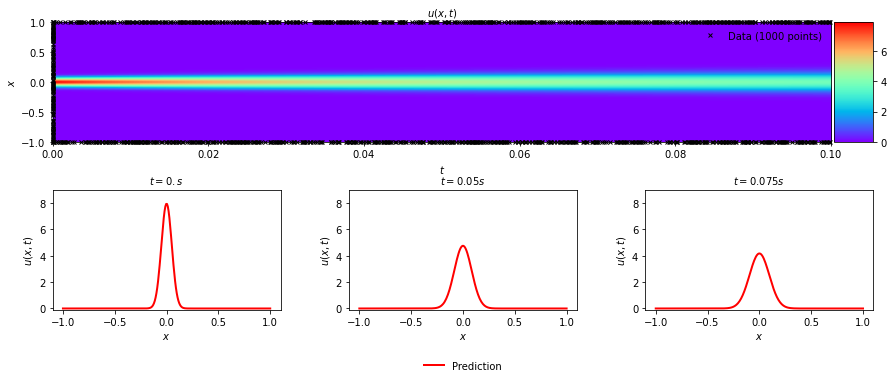

In [7]:
N_u = 1000 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,1000),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
solutionplot(u_pred,X_u_train,u_train)

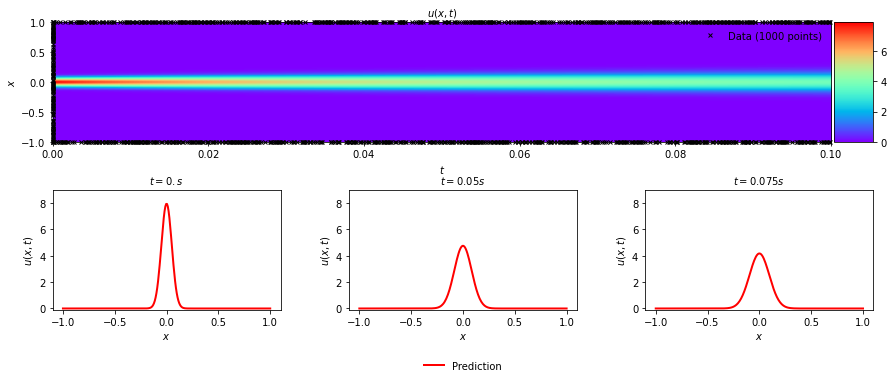

In [8]:
solutionplot(u_pred,X_u_train,u_train)

In [16]:
import pickle

filename = 'ornstein_uhlenbeck_central_ic.sav'
pickle.dump(results, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

In [11]:
u_pred.shape

(256, 1000)

# Plot of collocation points

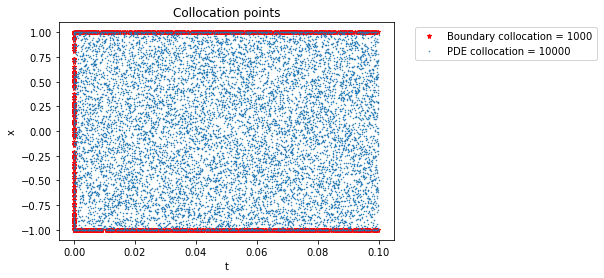

In [12]:
N_u = 1000 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

fig,ax = plt.subplots()

plt.plot(X_u_train[:,1], X_u_train[:,0], '*', color = 'red', markersize = 5, label = 'Boundary collocation = 1000')
plt.plot(X_f_train[:,1], X_f_train[:,0], 'o', markersize = 0.5, label = 'PDE collocation = 10000')

plt.xlabel('t')
plt.ylabel('x')
plt.title('Collocation points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig.savefig('collocation_points_Burgers.png', dpi = 500, bbox_inches='tight')

In [13]:

x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
t = np.linspace(0, 0.1, 1000)                     # 100 time points between 0 and 1 [100x1] 

X, T = np.meshgrid(x,t)
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_pred=PINN.evaluate(X_u_test)
u_pred = np.reshape(u_pred,(256,1000),order='F')  

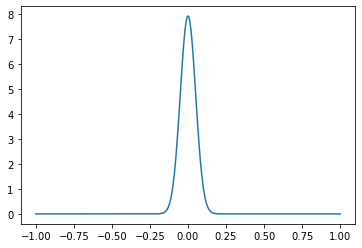

In [14]:
plt.plot(x, u_pred[:,1])


In [15]:
import ipywidgets

def inter_pred(time):
    time = int(time * 10000)
    plt.plot(x, u_pred[:,time])
    plt.xlim(-1, 1)
    plt.ylim(0, 8)
    plt.grid()
        
        
ipywidgets.interact(inter_pred, time=(0, 0.099, 0.007))

interactive(children=(FloatSlider(value=0.049, description='time', max=0.099, step=0.007), Output()), _dom_cla…

<function __main__.inter_pred(time)>